# Data Literacy
#### University of Tübingen, Winter Term 2021/22
## Exercise Sheet 4
&copy; 2021 Prof. Dr. Philipp Hennig & Nico Krämer & Emilia Magnani

This sheet is **due on Monday, November 22, 2021 at 10am sharp (i.e. before the start of the lecture).**

---

## Data estimation
Last week, we looked at maximum likelihood estimation for exit polls / election data in the context of the German general election in September 2021.
This week, we will continue the analysis and augment the maximum likelihood estimators from last week with uncertainty quantification.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.special

# For the docstrings / type hints
from typing import Union, Optional, Tuple

# A fixed random seed
rng = np.random.default_rng(seed=1)

The next snippet loads the data and extracts the results for one party, the true voting share of that party, and some other useful quantities.

In [2]:
# Load the data
data = pd.read_csv("data_slim.csv")


# Choose one party here.
my_party = "SPD"

# Grouped results
result_my_party = int(data[data["Gruppenname"] == my_party]["Anzahl"].sum())
result_others = int(data[data["Gruppenname"] != my_party]["Anzahl"].sum())

# True proportion of votes that `my_party` received
truth = result_my_party / (result_my_party + result_others)


# All votes as an array of strings
votes_all = np.concatenate(
    (np.tile(my_party, result_my_party), np.tile("Not " + my_party, result_others))
)

# An array of the relevant parties
parties_all = np.array([my_party, "Not " + my_party])

The next snippet provides a function that simulates an exit poll. You can use your solution from last week's sheet instead.

In [19]:
def exit_poll(
    rng: np.random.Generator,
    *,
    poll_size: int,
    votes: np.ndarray,
    parties: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray]:
    """Conduct an exit poll.

    Parameters
    ----------
    rng
        Random number generator.
    poll_size
        Poll size. How many people are polled.
    votes
        The true election results.
    parties
        List of parties.

    Returns
    -------
    Exit poll counts and full exit poll.
    """
    poll = rng.choice(votes, size=(poll_size,), replace=False)
    poll_counts = count(poll=poll[None, :], parties=parties)
    return poll_counts[0], poll


def count(poll: np.ndarray, parties: np.ndarray) -> np.ndarray:
    """Count the number of occurences of a party in an exit poll."""
    return np.count_nonzero(poll[..., None] == parties[None, None, :], axis=1)


# Some test that checks that the function works
exit_poll_counts, x = exit_poll(
    rng, poll_size=15, votes=votes_all, parties=parties_all
)


## Uncertainty quantification via Fisher information 

In an exit poll for an election with $K$ parties, the counts $N_k$ for the $k$th party follows a multinomial distribution, 
$$
p(N_1, ..., N_K \mid \pi_1, .., \pi_K) = \frac{\Gamma\left(\sum_k N_k + 1 \right)}{\prod_k \Gamma(N_k + 1)} \prod_{k=1}^K \pi_k^{N_k},
$$
where $\Gamma$ is the Gamma function.
Let $|N| = \sum_k N_k$. Given a sample $(N_1, ..., N_K)$ (an exit poll), the maximum likelihood estimate for $\pi = (\pi_1, ..., \pi_K)$ is
$$
\hat \pi = (N_1 / |N|, ..., N_K / |N|).
$$
In the following, we will consider the case of $K=2$ (the counts for one party, and the counts for "not" this party, i.e., all the others).
This reduces the multinomial distribution to a binomial distribution, with parameters $(\pi, 1 - \pi)$.
You know from the lecture that the Fisher information for this setup is
$$
I(\pi) = \frac{|N|}{\pi (\pi - 1)}.
$$
Asymptotically, the error of the MLE is Gaussian,
$ \hat{\pi} \sim \mathcal{N}\left(\hat{\pi};\pi_\text{truth},  - I(\hat \pi)^{-1}\right)$.

**Task:**
Use the formula for the Fisher information to write a function that computes the (asymptotic) covariance of the MLE. 

In [26]:
def covariance_scalar(probabilities: float, poll_size: int) -> float:
    """Fisher information matrix."""
    return probabilities * (1 - probabilities) / poll_size

# A test
covariance_scalar(0.25, 10_000_000)

1.875e-08

**Task:**
Conduct an (artificial) exit poll, and evaluate how the covariance evolves for increasing exit poll sizes $|N|$.
To this end, plot $f(x) = \mathcal{N}(x; \hat \pi, -I(\hat \pi)^{-1})$ and the true likelihood function $p(N \mid \pi)$ for $|N| \in \{10, 20, 50 \}$, and compare them to the true vote distribution $\pi_\text{truth}$.


In [27]:
from scipy.stats import norm, binom

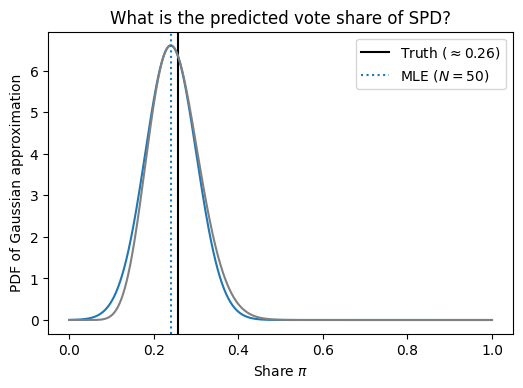

In [58]:
plt.figure(dpi=100)
plt.axvline(truth, color="k", label=f"Truth ($\\approx{np.round(truth, 2)}$)")


pi_my_party_wins = np.linspace(0., 1., num=1_000)
pi_candidates = np.stack((pi_my_party_wins, 1.0 - pi_my_party_wins), axis=1)

for poll_size, c in zip([50], ["C0", "C1", "C2", "C4", "C5"]):

    poll_counts, _ = exit_poll(
        rng, poll_size=poll_size, votes=votes_all, parties=parties_all
    )
    
    # Closed-form solution for MLE formula
    mle = poll_counts[0] / poll_size

    # How good is the MLE?
    cov = covariance_scalar(mle, poll_size)

    if cov == 0.0:
        print(mle, cov, poll_counts)
        raise ValueError("Covariance is zero.")

    x = pi_my_party_wins
    y_norm = norm(loc=mle, scale=np.sqrt(cov)).pdf(x)
    
    # True likelihood
    y_binom = binom.pmf(poll_counts[0], poll_size, x)
    
    # Scale
    y_binom_scaled = (
        y_binom
        * norm(loc=mle, scale=np.sqrt(cov)).pdf(mle)
        / binom.pmf(poll_counts[0], poll_size, mle)
    )
    plt.plot(x, y_norm, color=c)
    plt.plot(x, y_binom_scaled, color="gray")
    plt.axvline(mle, linestyle="dotted", color=c, label=f"MLE ($N={poll_size}$)")

plt.title(f"What is the predicted vote share of {my_party}?")
plt.xlabel("Share $\pi$")
plt.ylabel("PDF of Gaussian approximation")
plt.legend()
plt.show()

## Uncertainty quantification via bootstrap estimation

While in the current setting, we can compute the Fisher information in closed form, often, this is not the case.
An alternative is the bootstrap estimator, which resamples a given data set repeatedly to quantify the variability of an estimator.
More precisely, we resample the conducted exit poll with replacement and recompute the estimator.


Instead of the bootstrap estimator, one can also use a parameteric bootstrap. There, instead of resampling the data with replacement, we use the knowledge that $(N_1, ..., N_K) \sim p(N \mid \pi)$ follows a bi/multinomial distribution with parameter $\pi=(\pi_1, ..., \pi_K)$. Then, we can parametrise the bi/multinomial distribution with the MLE, sample from $p(N \mid \hat \pi)$ and recompute maximum likelihood estimates for each sample.


**Task:**
Implement the bootstrap estimator and the parametric bootstrap estimator for the MLE of $\pi$. Choose a poll size of, e.g., $|N|=1000$. Repeat the plot from above, but replace the Gaussian bell with a histogram of bootstrapped MLEs. Choose the number of bootstrap samples appropriately.

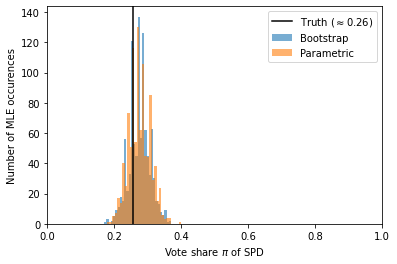

In [68]:
def resample(
    rng: np.random.Generator,
    *,
    poll: np.ndarray,
    parties: np.ndarray,
    num_resamples: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Resample M times from poll counts with replacements."""
    size = (num_resamples, poll.shape[0])
    samples = rng.choice(a=poll, size=size, replace=True)
    sample_counts = count(poll=samples, parties=parties)
    return sample_counts, samples


def resample_parametric(
    rng: np.random.Generator,
    *,
    probabilities: np.ndarray,
    parties: np.ndarray,
    num_resamples: int,
) -> Tuple[np.ndarray, np.ndarray]:
    size = (num_resamples, poll.shape[0])
    samples = rng.choice(a=parties, size=size, p=probabilities, replace=True)
    sample_counts = count(poll=samples, parties=parties)
    return sample_counts, samples


poll_size = 200
num_bootstrap_samples = 1000

poll_counts, poll = exit_poll(
    rng, poll_size=poll_size, votes=votes_all, parties=parties_all
)
mle = poll_counts / poll_size

poll_counts, poll_all = resample(rng, poll=poll, parties=parties_all, num_resamples=1)
poll_counts_parametric, poll_all = resample_parametric(
    rng, probabilities=mle, parties=parties_all, num_resamples=1
)


def bootstrap_mle(
    rng: np.random.Generator, *, poll: np.ndarray, parties: np.ndarray, num_straps: int
) -> np.ndarray:
    counts, _ = resample(rng, poll=poll, parties=parties, num_resamples=num_straps)
    return counts / np.sum(counts, axis=1)[:, None]


def bootstrap_parametric_mle(
    rng: np.random.Generator,
    *,
    probabilities: np.ndarray,
    parties: np.ndarray,
    num_straps: int,
) -> np.ndarray:
    counts, _ = resample_parametric(
        rng, parties=parties, probabilities=probabilities, num_resamples=num_straps
    )
    return counts / np.sum(counts, axis=1)[:, None]


boot = bootstrap_mle(
    rng, poll=poll, parties=parties_all, num_straps=num_bootstrap_samples
)
boot_param = bootstrap_parametric_mle(
    rng, probabilities=mle, parties=parties_all, num_straps=num_bootstrap_samples
)

mle = poll_counts[0] / poll_size

plt.axvline(truth, color="k", label=f"Truth ($\\approx{np.round(truth, 2)}$)")

# plt.axvline(mle, color="k", linestyle="dotted", label=f"MLE ($N={poll_size}$)")
plt.hist(boot[:, 0], alpha=0.6, bins=30, label="Bootstrap")
plt.hist(boot_param[:, 0], alpha=0.6,bins=30,  label="Parametric")
plt.legend()
plt.xlim((0,1))
plt.xlabel("Vote share $\pi$ of SPD")
plt.ylabel("Number of MLE occurences")
plt.show()

We can use the bootstrap estimator on a wide range of estimates. For example, we can quantify the uncertainty over estimating $P(\{\text{My Party}\} > \text{threshold})$.
For given exit poll $N=(N_1, ..., N_K)$, last week, we saw how to compute the probability of a party receiving more than a certain share of votes. Using the (parametric) bootstrap, we can resample the data and recompute this probability for each sample.

**Task:**
Implement this resampling, and plot 50 bootstrap samples each of which describes the probability of SPD exceeding 22% of votes, for increasing exit poll counts $|N|$. How large does the poll have to be for us to be confident about SPD exceeding 22% of votes?

In [80]:
def likelihood(**kwargs) -> np.ndarray:
    """Compute the likelihood of an observed exit poll given a probability distribution between the parties."""
    return np.exp(log_likelihood(**kwargs))


def log_likelihood(
    *,
    exit_poll_counts: np.ndarray,
    probabilities: np.ndarray,
    log_damping: Optional[int] = 1e-15
) -> np.ndarray:
    """Compute the likelihood of an observed exit poll given a probability distribution between the parties.

    Parameters
    ----------
    exit_poll_counts
        Exit poll results. List of counts the votes that each party received.
    probabilities
        Probabilities of each party receiving the vote.
    log_damping
        Damping value to be added to the logarithm. Avoids log(0).

    Returns
    -------
    Log-likelihood of an observed exit poll given a probability distribution between the parties.
    """
    return np.sum(np.log(probabilities + log_damping) * exit_poll_counts)


def poll_to_logprob(poll_counts: np.ndarray, pi_candidates: np.ndarray) -> np.ndarray:
    """Turn a list of poll counts into a list of log-probabilities."""
    log_likelihood_values = np.stack(
        [
            log_likelihood(exit_poll_counts=poll_counts, probabilities=p)
            for p in pi_candidates
        ]
    )

    probability_values_log = log_likelihood_values - scipy.special.logsumexp(
        log_likelihood_values
    )
    return probability_values_log


log_likelihood(exit_poll_counts=exit_poll_counts, probabilities=np.array([0.4, 0.6]))
likelihood(exit_poll_counts=exit_poll_counts, probabilities=np.array([0.4, 0.6]))

n_trials = np.logspace(
    start=np.log10(10),
    stop=np.log10(len(votes_all) / 200.0),
    num=10,
    endpoint=True,
    base=10,
    dtype=int,
)
threshold = 0.22
probs = []
means = []
stds = []


pi_my_party_wins = np.linspace(0, 1, num=600)
pi_candidates = np.stack((pi_my_party_wins, 1.0 - pi_my_party_wins), axis=1)

for n in n_trials:

    poll_counts, poll = exit_poll(
        rng, poll_size=n, votes=votes_all, parties=parties_all
    )

    poll_counts, polls = resample(rng, poll=poll, parties=parties_all, num_resamples=50)

    probability_values_log = np.stack(
        [
            poll_to_logprob(poll_counts=count, pi_candidates=pi_candidates)
            for count in poll_counts
        ]
    )

    probability_values = np.exp(probability_values_log)

    p = np.sum(probability_values[:, pi_my_party_wins >= threshold], axis=1)

    probs.append(p)
    means.append(np.mean(p))
    stds.append(np.sqrt(np.cov(p)))

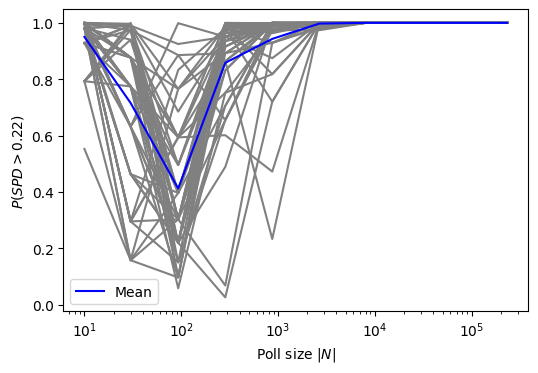

In [81]:
plt.figure(dpi=100)
plt.plot(n_trials, np.stack(probs, axis=0), color="gray")
plt.plot(n_trials, np.stack(means, axis=0), color="blue", label="Mean")
plt.xscale("log")
plt.xlabel("Poll size $|N|$")
plt.ylabel("$P(SPD > 0.22)$")
plt.legend()
plt.show()

Instead of the samples, we can also measure the evolution of the standard deviation of the samples for increasing exit poll size.

**Task:**
Plot the standard deviation of the bootstrap samples from above against the exit poll size. Compare this to the error.

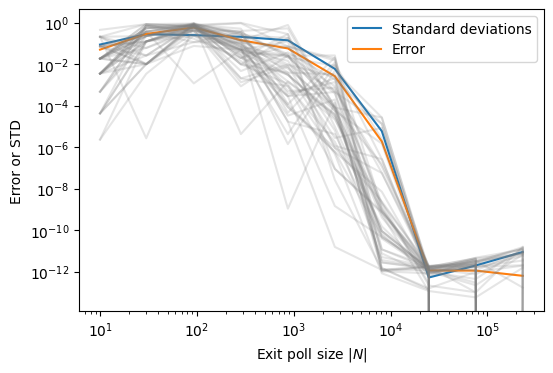

In [83]:
plt.figure(dpi=100)
plt.loglog(n_trials, np.stack(stds, axis=0), label="Standard deviations")
plt.loglog(n_trials, 1 - np.stack(means, axis=0) + 1e-12, label="Error")
plt.loglog(n_trials, 1 - np.stack(probs, axis=0) + 1e-12, color="grey", alpha=0.2)
plt.legend()
plt.xlabel("Exit poll size $|N|$")
plt.ylabel("Error or STD")
plt.show()